## Get data from Zenodo

In [2]:
import subprocess
import os

output_dir = './data/'
os.makedirs('./data/', exist_ok=True)

cmd1 = ["wget", "-c", "-P", output_dir, "https://zenodo.org/records/17143346/files/PE_O5Like_snr20.h5"] # PE file
cmd2 = ["wget", "-c", "-P", output_dir, "https://zenodo.org/records/17143346/files/injections_Ninj_2e7_O5Like_snr20.h5"] # inj file
cmd3 = ["wget", "-c", "-P", output_dir, "https://zenodo.org/records/17143346/files/parent_galaxy_catalog_1.6M_dVdz.h5"] # parent galaxy sample
cmd4 = ["wget", "-c", "-P", output_dir, "https://zenodo.org/records/17143346/files/PE_O5Like_snr20_pixelated_nsidelist512-256-128-64-32-16-8_meanpixels15_skyconf0.9_nestFalse.h5"] # pixelated pe
subprocess.run(cmd1, capture_output=True, text=True)
subprocess.run(cmd2, capture_output=True, text=True)
subprocess.run(cmd3, capture_output=True, text=True)
subprocess.run(cmd4, capture_output=True, text=True)

KeyboardInterrupt: 

## Load data and pixelate catalogue (or load one already pixelated)

In [11]:
import sys
os.environ["CHIMERA_ENABLE_GPU"] = "False"
sys.path.append(os.getcwd()+'/../')
from CHIMERA import data as data
import h5py


fpe = "./data/PE_O5Like_snr20.h5"
gw_pe_det = data.load_gw_pe_samples(fpe, parameters=['m1det', 'm2det', 'dL', 'ra', 'dec', 'phi', 'theta'])
gw_pe_det = gw_pe_det.update(pe_prior=gw_pe_det.dL**2)

# You can skip the following line if you already have the pixelated PE
"""
nside_list = [512, 256, 128, 64, 32, 16, 8]
mean_npixels_event = 15
prefix = "./data/PE_O5Like_snr20"
nest = False
sky_conf = 0.9
gw_pe_det_pixelated = data.pixelize_gw_catalog(gw_pe_det,
                       nside_list,
                       mean_npixels_event,
                       sky_conf,
                       nest,
                       prefix,
                       ret_datastruct=True)
"""

# Reload pixelated PE
f_gw_pix = './data/PE_O5Like_snr20_pixelated_nsidelist512-256-128-64-32-16-8_meanpixels15_skyconf0.9_nestFalse.h5'
gw_pe_det_pixelated = data.load_pixelated_gw_catalog(f_gw_pix)

2025-09-17 11:12:05,347 - CHIMERA - INFO - Precomputing Healpix pixels (NSIDE=512, NEST=False)
2025-09-17 11:12:05,401 - CHIMERA - INFO - Precomputing Healpix pixels (NSIDE=256, NEST=False)
2025-09-17 11:12:05,451 - CHIMERA - INFO - Precomputing Healpix pixels (NSIDE=128, NEST=False)
2025-09-17 11:12:05,497 - CHIMERA - INFO - Precomputing Healpix pixels (NSIDE=64, NEST=False)
2025-09-17 11:12:05,541 - CHIMERA - INFO - Precomputing Healpix pixels (NSIDE=32, NEST=False)
2025-09-17 11:12:05,583 - CHIMERA - INFO - Precomputing Healpix pixels (NSIDE=16, NEST=False)
2025-09-17 11:12:05,624 - CHIMERA - INFO - Precomputing Healpix pixels (NSIDE=8, NEST=False)
2025-09-17 11:12:44,964 - CHIMERA - INFO - Optimal NSIDEs: [ 32  64 128 256 512]
2025-09-17 11:12:44,965 - CHIMERA - INFO - Event counts: [  9 104 153  31   3]


## Instantiate population objects

In [12]:
from CHIMERA.cosmo import flrw
from CHIMERA.mass import plp
from CHIMERA.rate import madau_dickinson
from CHIMERA.catalog import dVdz_completeness, pixelated_catalog
from CHIMERA import population, compute_z_grids

fname_gal    = "./data/parent_galaxy_catalog_1.6M_dVdz.h5"

cosmo = flrw(H0 = 70., 
             Om0=0.25,
            z_max = 5.)

z_grids = compute_z_grids(cosmo, 
                          gw_pe_det_pixelated, 
                          cosmo_prior = {'H0':[20,200]}, 
                          z_int_res = 500,)

completeness = dVdz_completeness(z_range= [0.073, 1.3]) # mask_file for 
gal_cat = pixelated_catalog(completeness, 
                            #gal_cat_file='galcat_test.h5',
                            # if the argument above is None it is necessary to specify the argument below to compute p_cat
                            cosmo = cosmo,
                            z_grids = z_grids, 
                            fname_data_gal = fname_gal, 
                            data_gw_pixelated = gw_pe_det_pixelated, 
                            z_err = 0.001,
                            out_file = 'galcat_test.h5'
                           )

mass = plp()
rate = madau_dickinson(gamma = 2.7,
                       kappa =  3.,
                       zp = 2.)

population = population(cosmo, mass, rate, gal_cat=gal_cat, scale_free=True)

2025-09-17 11:12:57,229 - CHIMERA - INFO - Computing catalog pixel indexes for nside=32
2025-09-17 11:12:57,291 - CHIMERA - INFO - Computing catalog pixel indexes for nside=64
2025-09-17 11:12:57,358 - CHIMERA - INFO - Computing catalog pixel indexes for nside=128
2025-09-17 11:12:57,419 - CHIMERA - INFO - Computing catalog pixel indexes for nside=256
2025-09-17 11:12:57,494 - CHIMERA - INFO - Computing catalog pixel indexes for nside=512
2025-09-17 11:12:57,566 - CHIMERA - INFO - Computing p_cat ...


## Plot pixelization scheme

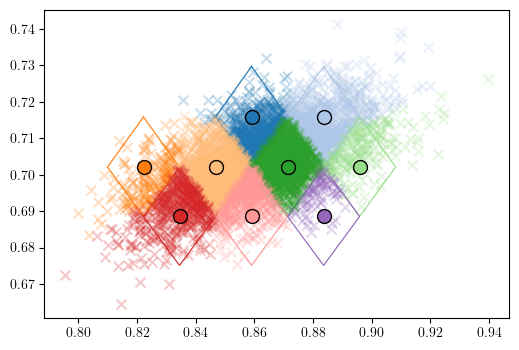

In [13]:
from CHIMERA.utils.plotting import plot_pixelization
import matplotlib.pyplot as plt

plot_pixelization(gw_pe_det_pixelated, 5)

## Instantiate bias object

In [14]:
from CHIMERA import selection_function
from CHIMERA.utils.config import jax, jnp
from tqdm import tqdm 

file_inj = "./data/injections_Ninj_2e7_O5Like_snr20.h5"
gw_inj_data = data.load_injection_data(file_inj, snr_cut=20, return_struct = True)
# inj_prior *= 1000 needed for LVK injection drawn from \pi_{draw} in which ddL/dz is in Mpc instead of Gpc

sel_fcn = selection_function(gw_inj_data, N_inj=20*1e6)

## Instantiate the hyperlikelihood 

In [15]:
from CHIMERA import hyperlikelihood


like_jax = hyperlikelihood(  
    # data
    gw_pe_det_pixelated,
    # z_grids
    z_grids,
    # pop model
    population=population,
    # bias model
    selection_function=sel_fcn,
    # KDE settings
    kind_p_gw3d = 'marginalized', # 'full', 'approximated'
    kernel='epan', # 'epan'
    bw_method=None,
    cut_grid=2,
    binning=True,
    num_bins=200,
)

2025-09-17 11:14:03,479 - CHIMERA - INFO - Created hyperlikelihood model. Using 300 GW events.


## 1d over H0

100it [02:52,  1.73s/it]


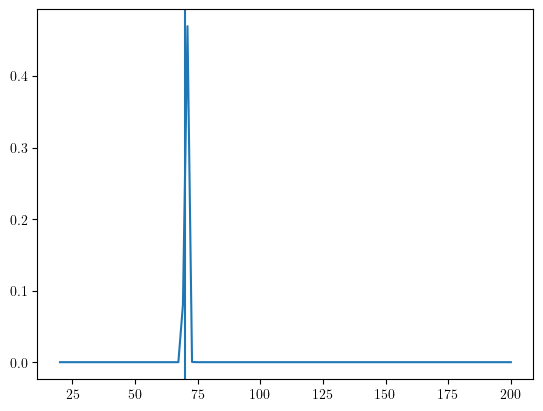

In [16]:
import numpy as np
import jax.numpy as jnp
import tqdm
import matplotlib.pyplot as plt

H0 = jnp.linspace(20, 200, 100)
# res_H0 = np.zeros((H0.shape[0], like_jax.z_int_res))
res_H0 = np.zeros_like(H0)

for i, h0 in tqdm.tqdm(enumerate(H0)):
  res = like_jax(H0 = h0)
  res_H0[i] = res
  
# exponentiate and normalize

post_jax = res_H0.copy()
post_jax -= np.nanmax(post_jax)
post_jax = np.exp(post_jax)
post_jax /= np.trapz(post_jax, H0)

plt.plot(H0, post_jax)
plt.axvline(70)

In [17]:
res_H0

array([            -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf,             -inf,
                   -inf,             -inf, -1.79769313e+308,
       -1.79769313e+308, -1.79769313e+308, -1.79769313e+308,
       -9.79836159e+002, -7.31243655e+002, -5.21184732e+002,
       -3.32616711e+002, -1.94542772e+002, -1.24756596e+002,
       -9.37084217e+001, -7.10624002e+001, -4.88577766e+001,
       -3.56948409e+001, -3.39245087e+001, -4.12929270e+001,
       -5.39441059e+001, -6.92905505e+001, -8.92816220e+001,
       -1.17894265e+002, -1.61531708e+002, -1.63370417e+002,
       -1.75137907e+002, -2.01637890e+002, -2.44362857e+002,
       -3.00929628e+002, -3.65652742e+002, -4.19818312e+002,
       -4.91131564e+002, -5.73302776e+002, -6.45276375e+002,
       -7.31619619e+002, -8.31286432e+002, -1.79769313e+308,
       -1.79769313e+308,